In [1]:
# All the packages

import tkinter as tk 
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import seaborn as sb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from operator import itemgetter
from urllib.request import urlopen
from bs4 import BeautifulSoup

In [2]:
# Import and read 2019 & 2020 NBA player stats
playerstats_2019 = pd.read_csv('2018_2019_data.csv')
playerstats_2020 = pd.read_csv('2019_2020_data.csv')


In [3]:
# Select specific columns for future analysis

playerstats_2019 = playerstats_2019[['Player', 'PTS', 'STL', 'BLK','Pos_x','G_x','MP_x','AST','TRB','3P%','FG%','FT%','eFG%','PER','TS%','ORB%','DRB%','STL%','BLK%','USG%','WS','BPM','VORP']]
playerstats_2020 = playerstats_2020[['Player', 'PTS', 'STL', 'BLK', 'Pos_x','G_x','MP_x','AST','TRB','3P%','FG%','FT%','eFG%','PER','TS%','ORB%','DRB%','STL%','BLK%','USG%','WS','BPM','VORP']]

playerstats_2019.columns = ['Player', 'PTS', 'STL', 'BLK','Pos_x','G_x','MP_x','AST','TRB','3P%','FG%','FT%','eFG%','PER','TS%','ORB%','DRB%','STL%','BLK%','USG%','WS','BPM','VORP']
playerstats_2020.columns = ['Player', 'PTS', 'STL', 'BLK','Pos_x','G_x','MP_x','AST','TRB','3P%','FG%','FT%','eFG%','PER','TS%','ORB%','DRB%','STL%','BLK%','USG%','WS','BPM','VORP']


player_winshares_2019 = playerstats_2019[['Player', 'WS']]
current_player_winshares_2020 = playerstats_2020[['Player', 'WS']]

# Win Shares Distrubtion among all the players (2019)

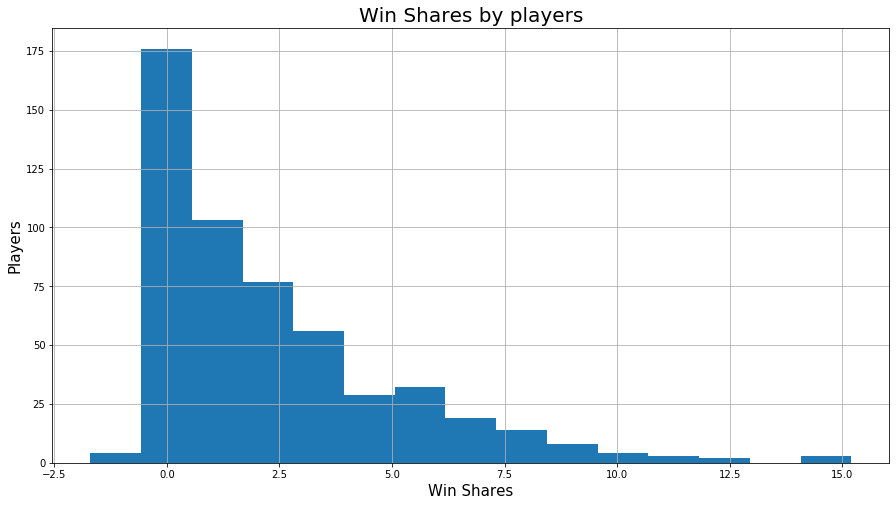

In [4]:
plt.figure(figsize = (15,8))
plt.hist(player_winshares_2019['WS'], bins = 15)
plt.grid()
plt.xlabel('Win Shares', size = 15)
plt.ylabel('Players', size = 15)
plt.title('Win Shares by players', size = 20);

The odd takeaway from the distribution is the number of players with 0 win shares. After further analysis, I was able to find that there was a high number of players that barely played at all. Although these players are on NBA rosters, that doesn't mean they will not have significant impact to both the team and their own individual stats. Therefore, I updated the data to only include players that had played at least 30 games and averaged at least 20 minutes of playing time per game. Here's what the distribution of win shares looks like after cleaning out the data:

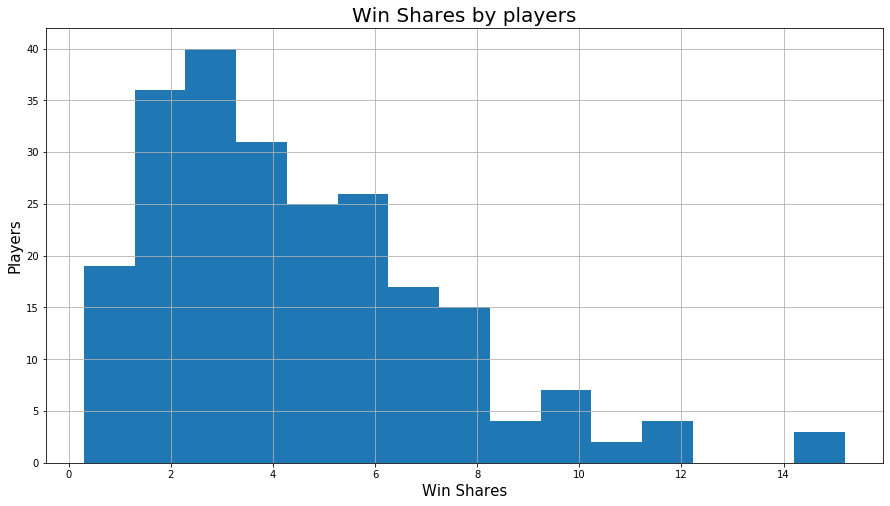

In [5]:
# Select players who have played more than 30 games in the season and who averaged 20 mins per game
playerstats_2019 = playerstats_2019[playerstats_2019['G_x'] > 30]
playerstats_2020 = playerstats_2020[playerstats_2020['G_x'] > 30]

playerstats_2019 = playerstats_2019[playerstats_2019['MP_x'] > 20]
playerstats_2020 = playerstats_2020[playerstats_2020['MP_x'] > 20]

playerstats_2019 = playerstats_2019[playerstats_2019['WS'] > 0]
playerstats_2020 = playerstats_2020[playerstats_2020['WS'] > 0]

# Plot Histogram once again after the changes
plt.figure(figsize = (15,8))
plt.hist(playerstats_2019['WS'], bins = 15)
plt.grid()
plt.xlabel('Win Shares', size = 15)
plt.ylabel('Players', size = 15)
plt.title('Win Shares by players', size = 20);

# Which features should be used for the model?

# Random Forest

In [6]:
# Fitting random forest regression to the dataset
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.ensemble import RandomForestRegressor

In [7]:
# Select x and y data and convert to numpy array
features = ['G_x','MP_x','PER','FG%','AST','STL','TS%','BLK','PTS','eFG%','USG%','BPM','VORP']
x_data = playerstats_2019[features].to_numpy()
y_data = playerstats_2019[['WS']].to_numpy()
y_data = y_data.reshape(y_data.shape[0], )

In [8]:
# Create regressor object
regressor = RandomForestRegressor(n_estimators=200)

In [9]:
# Fit the regressor with x and y data
regressor.fit(x_data, y_data)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [10]:
# Sort the values from highest to lowest
sorted_indices = np.argsort(regressor.feature_importances_)[::-1]

In [11]:
# Print the feature ranking
for index in sorted_indices:
    print(f"{features[index]}: {regressor.feature_importances_[index]}")

VORP: 0.7059520140829876
PER: 0.11562583321332494
BPM: 0.06269802386499909
TS%: 0.031828795645559675
G_x: 0.022566104455509987
PTS: 0.01442473256917547
MP_x: 0.008781311936984988
FG%: 0.00805715005076711
eFG%: 0.007070201095175569
STL: 0.0070536675865229895
USG%: 0.00685422982275183
AST: 0.005195671203520905
BLK: 0.003892264472719833


It kinda seems that only using VORP we can conclude which player has the most win shares.

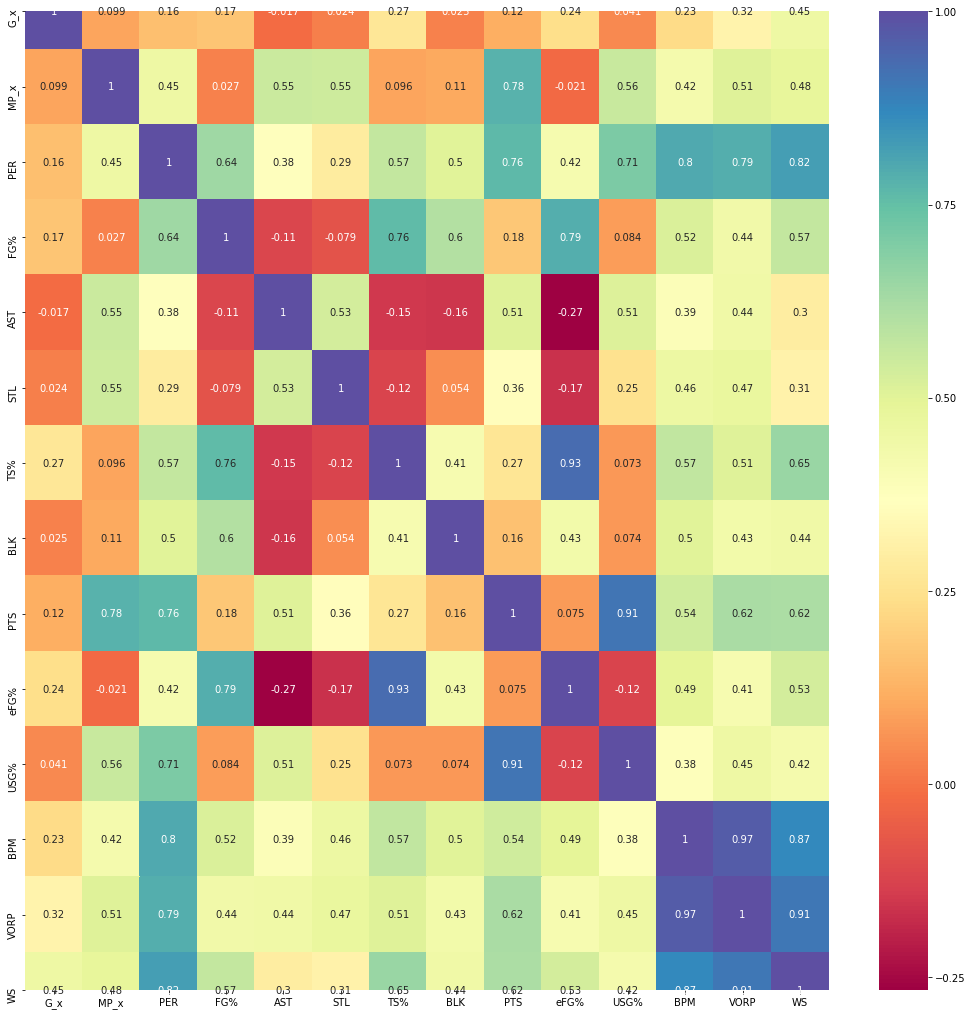

In [12]:
# Plot heatmap to see which features have strong corrletation to win shares and one another
playerstats_2019 = playerstats_2019[features + ["WS"]]

fig = plt.figure(figsize=(18, 18))

fig.set_facecolor('white')

sns.heatmap(playerstats_2019.corr(), annot=True, cmap="Spectral")

# Model Selection and Testing¶

Perform supervised regression machine learning analysis using the following models to see which model can give us accurate win shares:

 - Linear Regression
 - Support Vector Regression
 - k-Nearest Neighbors Regression